In [37]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
import math
import argparse 
import os
import collections
import json
import re
import pprint
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
import random 
from tensorflow.contrib.tensorboard.plugins import projector
from IPython import display
%matplotlib inline 

In [31]:
# parse json to files and actions

def parse_json(filepath):
    '''
    function used to parse json of each commit json file
    
    Args:
        filepath_list - list of filepaths
    
    Returns:
        files_json - list object contains parsed information
    
    '''
    number_of_files = []
    files_json = []
    
    # each commits
    files = os.listdir(filepath)
    for path in files:
        with open(filepath + path,'rb') as f:
            data = json.load(f)
            files_list = []
            # each file in commits
            for file in data['files']:
                # parse only cluster file
                for key in file.keys():
                    if re.match('^.*_cluster$',key):
                        actions_list = []
                        actions = file[key]['actions']
                        # each action in file
                        for action in actions:
                            actions_list.append(action['root'])
                        files_list.append(actions_list)
        
        files_json.append(files_list)        
    
    # return
    return files_json
pwd = os.getcwd()
folder_path = pwd + '/tmp_JSON_labeled_commits/'
files = parse_json(folder_path)
print(files[0])

[['INS Block to MethodDeclaration at 6', 'MOVE from Block', 'MOVE from Block', 'UPDATE from add to addEvent', 'INS Block to EnhancedForStatement at 2', 'MOVE from Block', 'DEL SimpleName: externalEventQueue', 'DEL Block', 'DEL SimpleName: externalEventQueue', 'DEL Block'], ['MOVE from Block', 'UPDATE from triggerEvent to addEvent', 'MOVE from Block', 'DEL TryStatement', 'DEL TryStatement'], ['MOVE from MethodDeclaration', 'MOVE from Block', 'MOVE from Block', 'UPDATE from triggerEvent to addEvent', 'DEL TryStatement', 'DEL Block']]


In [3]:
def preprocess_roots(files_data):
    counting = {}
    for file_index, files in enumerate(files_data):
        for root_index, roots in enumerate(files):
            for action_index, actions in enumerate(roots):
                temp = actions.split(' at ')[0]
                tempq = []
                if temp.startswith('INS'):
                    tempq.append('INS')
                    words = [temp.split('INS ')[1].split('to ')[0].strip()
                             ] + [temp.split('INS ')[1].split('to ')[-1].strip()]
                    for items in words:

                        items = items.split(': ')[0]
                        tempq.append(items)
                    temp = '_'.join(tempq)

                if temp.startswith('UPDATE'):
                    temp = 'UPDATE'
                if temp.startswith('MOVE'):
                    temp2 = temp.split(' from ')[1]
                    tempq.append('MOVE')
                    tempq.append(temp2.split(': ')[0])
                    temp = '_'.join(tempq)

                if temp.startswith('DEL'):
                    tempq.append('DEL')
                    tempq.append(temp.split('DEL ')[1].split(': ')[0])
                    temp = '_'.join(tempq)
                counting[temp] = counting.get(temp, 0) + 1
                files_data[file_index][root_index][action_index] = temp
    dic = {}
    i = 0
    for k, v in counting.items():
        dic[k] = i  
        i += 1
    return dic, files_data, counting 

dic, datas, freq_dict = preprocess_roots(files)

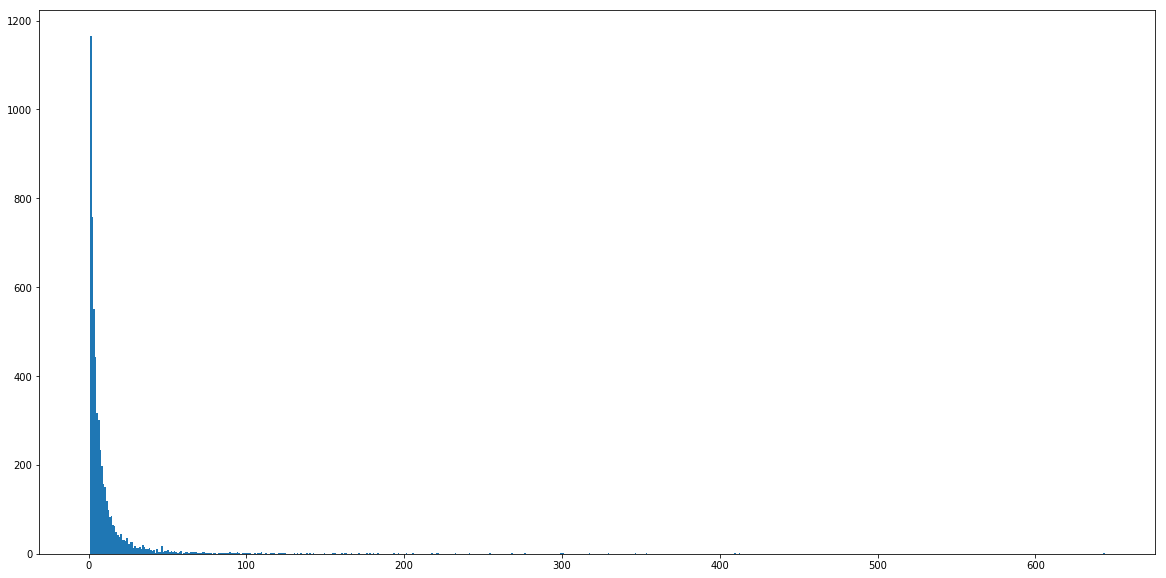

In [32]:
def actions2sentence(datas):
    data_total = []
    for files in datas:
        data4file = []
        for roots in files:
            sentence = ' '.join(roots)
            data4file.append(sentence)
        data_total.append(data4file)
    return data_total


training_data = actions2sentence(datas)

def get_seqlength(training_data):
    max_root_len = 0
    seqlength_list = []
    for items in training_data:
        for item in items:
            seqlength_list.append(len(item.split(" ")))
            if len(item.split(" ")) >  max_root_len: 
                max_root_len = len(item.split(" "))
    return max_root_len, seqlength_list

def plot_hist(seqlength_list): 
    plt.figure(figsize=(20,10))
    number_of_files = np.array(seqlength_list)
    bincount = np.bincount(seqlength_list)
    x = np.arange(1, len(bincount)+1)
    n, bins, patches = plt.hist(seqlength_list,x)

max_seqlength, sequence_list = get_seqlength(training_data)
plot_hist(sequence_list)


In [33]:
print(training_data[0]) # output is a single commit 
print("  ")
for keys, vals in dic.items(): 
    print(keys, vals)

['INS_Block_MethodDeclaration MOVE_Block MOVE_Block UPDATE INS_Block_EnhancedForStatement MOVE_Block DEL_SimpleName DEL_Block DEL_SimpleName DEL_Block', 'MOVE_Block UPDATE MOVE_Block DEL_TryStatement DEL_TryStatement', 'MOVE_MethodDeclaration MOVE_Block MOVE_Block UPDATE DEL_TryStatement DEL_Block']
  
INS_Block_MethodDeclaration 0
MOVE_Block 1
UPDATE 2
INS_Block_EnhancedForStatement 3
DEL_SimpleName 4
DEL_Block 5
DEL_TryStatement 6
MOVE_MethodDeclaration 7
INS_SimpleName_InfixExpression 8
INS_NumberLiteral_InfixExpression 9
DEL_MethodInvocation 10
DEL_NumberLiteral 11
DEL_ImportDeclaration 12
INS_ImportDeclaration_CompilationUnit 13
INS_MethodInvocation_Assignment 14
DEL_MethodDeclaration 15
DEL_IfStatement 16
MOVE_InfixExpression 17
DEL_ExpressionStatement 18
DEL_ParenthesizedExpression 19
INS_VariableDeclarationStatement_Block 20
INS_ExpressionStatement_Block 21
DEL_VariableDeclarationStatement 22
INS_QualifiedName_MethodInvocation 23
MOVE_MethodInvocation 24
INS_MethodDeclaration_T

In [40]:
## Global variable 
data_id = 0
def word2vec_basic(log_dir, dic, freq_dict, training_data):
    """ Word2vec model """
    # Create the directory for TensorBoard variables if there is not.
    
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    # Generate reverse dictionary from dictionary 
    rev_dic = dict(zip(dic.values(), dic.keys()))
    
    def concat_train_data(training_data): 
        concat_data = ""
        tmp_list = []
        for items in training_data: 
            tmp_list += items
        concat_data = " ".join(tmp_list)
        return concat_data
    
    def tokenize_train_data(concat_train_data): 
        data = []
        for word in concat_train_data.split(): 
            index = dic.get(word)
            data.append(index)
        return data  
            
    
    # Generate batch for skip-gram model: 
    def generate_batch(batch_size, num_skips, skip_window): 
        global data_id 
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window 
        batch = np.ndarray(shape=(batch_size), dtype=np.int32)
        labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
        span = 2 * skip_window + 1  # context of a word 
        buffer = collections.deque(maxlen=span)  # pylint: disable=redefined-builtin
        
        # get concatenated data 
        data = concat_train_data(training_data)
        data = tokenize_train_data(data)  # convert root to is index 
        
        if data_id + span > len(data):
            data_id = 0
        buffer.extend(data[data_id:data_id + span])
        data_id += span
        for i in range(batch_size // num_skips):
            # all range of words that are not equal to window size
            context_words = [w for w in range(span) if w != skip_window] 
            words_to_use = random.sample(context_words, num_skips)
            for j, context_word in enumerate(words_to_use):
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j, 0] = buffer[context_word]
            if data_id == len(data):
                buffer.extend(data[0:span])
                data_id = span
            else:
                buffer.append(data[data_id])
                data_id += 1
            # Backtrack a little bit to avoid skipping words in the end of a batch
        data_id = (data_id + len(data) - span) % len(data)
        return batch, labels

    batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
    for i in range(8): 
        print(batch[i], rev_dic[batch[i]], '->', labels[i, 0], rev_dic[labels[i, 0]])
        
    # Build and train skip-gram model. 
    
    #Hyperparameters 
    batch_size = 128
    embedding_size = 128  # Dimension of the embedding vector.
    skip_window = 1   # How many words to consider left and right.
    num_skips = 2     # How many times to reuse an input to generate a label.
    num_sampled = 64  # Number of negative examples to sample.
    
    #Select random sample of most frequent words for model validation 
    valid_size = 16  # Random set of words to evaluate similarity on.
    valid_window = 100  # Only pick dev samples in the head of the distribution.
    valid_examples = np.random.choice(valid_window, valid_size, replace=False)
    
    graph = tf.Graph()
    
    with graph.as_default(): 
        #input data 
        with tf.name_scope('inputs'): 
            train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
            train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
            valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
        #ops and variables pinned to the CPU because of missing GPU implementation 
        with tf.device('/cpu:0'): 
            #Loopk up embeddings for inputs 
            with tf.name_scope('embeddings'): 
                embeddings = tf.Variable(tf.random_uniform([len(dic), embedding_size], -1.0, 1.0))
                embed = tf.nn.embedding_lookup(embeddings, train_inputs)
                #Construct the variables for the NCE loss 
            with tf.name_scope('weights'): 
                nce_weights = tf.Variable(tf.truncated_normal([len(dic), embedding_size], stddev=1.0/math.sqrt(embedding_size)))
            with tf.name_scope('biases'): 
                nce_biases = tf.Variable(tf.zeros([len(dic)]))
        # Compute the average NCE loss for the batch.
        # tf.nce_loss automatically draws a new sample of the negative labels each
        # time we evaluate the loss.
        # Explanation of the meaning of NCE loss:
        # http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/        
        with tf.name_scope('loss'): 
            loss = tf.reduce_mean(
                tf.nn.nce_loss(
                    weights=nce_weights, 
                    biases=nce_biases, 
                    labels=train_labels, 
                    inputs=embed, 
                    num_sampled=num_sampled, 
                    num_classes=len(dic)
                )
            )
        #Add the loss value as a scaler to the summary. 
        tf.summary.scalar("loss", loss)
        #Construct the SGD optimizer using a learninig rate of 1.0 
        with tf.name_scope('optimizer'): 
            optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
        # Compute the cosine similarity between minibatch examples and all
        # embeddings.
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
        normalized_embeddings = embeddings / norm
        valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
        similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)
        # Merge all summaries.
        merged = tf.summary.merge_all()
        # Add variable initializer.
        init = tf.global_variables_initializer()
        # Create a saver.
        saver = tf.train.Saver()
    # Step 5: Begin training.
    num_steps = 100001
    
    with tf.compat.v1.Session(graph=graph) as session: 
        #open a writer to write summaries 
        writer = tf.summary.FileWriter(log_dir, session.graph)
        #We must initialize all variables before we use them. 
        init.run()
        print('Initialized')
        average_loss = 0
        avg_loss_list = []
        steps_list = []
        for step in range(num_steps): 
            batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
            feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
            # Define metadata variable.
            run_metadata = tf.RunMetadata()
            # We perform one update step by evaluating the optimizer op (including it
            # in the list of returned values for session.run()
            # Also, evaluate the merged op to get all summaries from the returned
            # "summary" variable. Feed metadata variable to session for visualizing
            # the graph in TensorBoard.
            _, summary, loss_val = session.run([optimizer, merged, loss], feed_dict=feed_dict, run_metadata=run_metadata)
            average_loss += loss_val 
            #Add returned summaries to writer in each step. 
            writer.add_summary(summary, step)
            #Add metadata to visualize the graph for the last run. 
            if step == (num_steps - 1):
                writer.add_run_metadata(run_metadata, 'step%d' % step) 
            if step % 200 == 0: 
                if step > 0: 
                    average_loss /= 200 
                    avg_loss_list.append(average_loss)
                    steps_list.append(step)
                # The average loss is an estimate of the loss over the last 2000
                # batches.
                print('Average loss at step ', step, ': ', average_loss)
                average_loss = 0 
            #Note that this is expensive (~20% slowdown if computed every 500 steps)
            if step % 1000 == 0: 
                sim = similarity.eval()
                for i in range(valid_size): 
                    valid_word = rev_dic[valid_examples[i]]
                    top_k = 8  # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                    log_str = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = rev_dic[nearest[k]]
                        log_str = '%s %s,' % (log_str, close_word)
                    print(log_str)
                    print("\n")
            final_embeddings = normalized_embeddings.eval()
            #Write corresponding labels for the embeddings
            with open(log_dir + '/metadata.tsv', 'w') as f:
                for i in range(len(dic)): 
                    f.write(rev_dic[i] + '\n')
            # Save the model for chpts 
            saver.save(session, os.path.join(log_dir, 'model.ckpt'))
            # Create a configuration for visualizing embeddings with the labels in
            # TensorBoard.
            config = projector.ProjectorConfig()
            embedding_conf = config.embeddings.add()
            embedding_conf.tensor_name = embeddings.name
            embedding_conf.metadata_path = os.path.join(log_dir, 'metadata.tsv')
            projector.visualize_embeddings(writer, config)
        writer.close()
        return avg_loss_list, steps_list
        # Step 6: Visualize the embeddings.
        # pylint: disable=missing-docstring
        # Function to draw visualization of distance between embeddings.
        def plot_with_labels(low_dim_embs, labels, filename):
            assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
            plt.figure(figsize=(18, 18))  # in inches
            for i, label in enumerate(labels):
                x, y = low_dim_embs[i, :]
                plt.scatter(x, y)
                plt.annotate(
                    label,
                    xy=(x, y),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
                plt.savefig(filename)
        try:
            # pylint: disable=g-import-not-at-top
            from sklearn.manifold import TSNE
            import matplotlib.pyplot as plt
            tsne = TSNE(
                perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
            plot_only = 500
            low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
            labels = [rev_dic[i] for i in range(plot_only)]
            plot_with_labels(low_dim_embs, labels, os.path.join(gettempdir(), 'tsne.png'))
        except ImportError as ex:
            print('Please install sklearn, matplotlib, and scipy to show embeddings.')
            print(ex)


In [42]:
# All functionality is run after tf.compat.v1.app.run() (b/122547914). This
# could be split up but the methods are laid sequentially with their usage for
# clarity.
def main(unused_argv):
  # Give a folder path as an argument with '--log_dir' to save
  # TensorBoard summaries. Default is a log folder in current directory.
    current_path = os.path.dirname(os.path.realpath(sys.argv[0]))

    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--log_dir',
        type=str,
        default=os.path.join(current_path, 'log'),
        help='The log directory for TensorBoard summaries.')
    flags, unused_flags = parser.parse_known_args()
    avg_loss_list, steps_list = word2vec_basic(flags.log_dir, dic, freq_dict, training_data)
    plt.figure(figsize(20, 20))
    plt.plot(avg_loss_list, steps_list)
    plt.title("Avg Loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
if __name__ == '__main__':
    tf.app.run()

18 DEL_ExpressionStatement -> 18 DEL_ExpressionStatement
18 DEL_ExpressionStatement -> 18 DEL_ExpressionStatement
18 DEL_ExpressionStatement -> 18 DEL_ExpressionStatement
18 DEL_ExpressionStatement -> 18 DEL_ExpressionStatement
18 DEL_ExpressionStatement -> 18 DEL_ExpressionStatement
18 DEL_ExpressionStatement -> 18 DEL_ExpressionStatement
18 DEL_ExpressionStatement -> 18 DEL_ExpressionStatement
18 DEL_ExpressionStatement -> 18 DEL_ExpressionStatement
Initialized
Average loss at step  0 :  104.33430480957031
Nearest to INS_IfStatement_Block: INS_FieldDeclaration_EnumDeclaration, MOVE_CreationReference, INS_Block_SwitchStatement, INS_Block_Block, DEL_ExpressionStatement, INS_InfixExpression_VariableDeclarationFragment, INS_FieldAccess_ClassInstanceCreation, INS_ClassInstanceCreation_ConditionalExpression,


Nearest to DEL_InfixExpression: INS_MemberRef_TagElement, INS_ForStatement_SwitchStatement, INS_MethodInvocation_ConstructorInvocation, DEL_NormalAnnotation, INS_NormalAnnotation_Arr

Average loss at step  1200 :  1.3565546128955236e+19
Average loss at step  1400 :  5.17220310395588e+27
Average loss at step  1600 :  nan
Average loss at step  1800 :  nan
Average loss at step  2000 :  nan
Nearest to INS_IfStatement_Block: DEL_ContinueStatement, DEL_WildcardType, INS_TypeDeclaration_AnonymousClassDeclaration, MOVE_InstanceofExpression, INS_MethodInvocation_InstanceofExpression, INS_QualifiedName_EnhancedForStatement, INS_SimpleType_CastExpression, INS_ExpressionStatement_IfStatement,


Nearest to DEL_InfixExpression: DEL_ContinueStatement, DEL_WildcardType, INS_TypeDeclaration_AnonymousClassDeclaration, MOVE_InstanceofExpression, INS_MethodInvocation_InstanceofExpression, INS_QualifiedName_EnhancedForStatement, INS_SimpleType_CastExpression, INS_ExpressionStatement_IfStatement,


Nearest to MOVE_VariableDeclarationStatement: DEL_ContinueStatement, DEL_WildcardType, INS_TypeDeclaration_AnonymousClassDeclaration, MOVE_InstanceofExpression, INS_MethodInvocation_Instanceof

Average loss at step  3200 :  nan
Average loss at step  3400 :  nan
Average loss at step  3600 :  nan
Average loss at step  3800 :  nan


KeyboardInterrupt: 